In [ ]:
!pip install ultralytics


#### Import Required Modules

In [2]:
import ultralytics
from ultralytics import YOLO
from IPython.display import display, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
ultralytics.checks()

Ultralytics YOLOv8.2.78  Python-3.9.19 torch-2.4.0+cpu CPU (Intel Core(TM) i7-1065G7 1.30GHz)
Setup complete  (8 CPUs, 15.8 GB RAM, 447.0/475.7 GB disk)


#### Detect object using Yolo v8

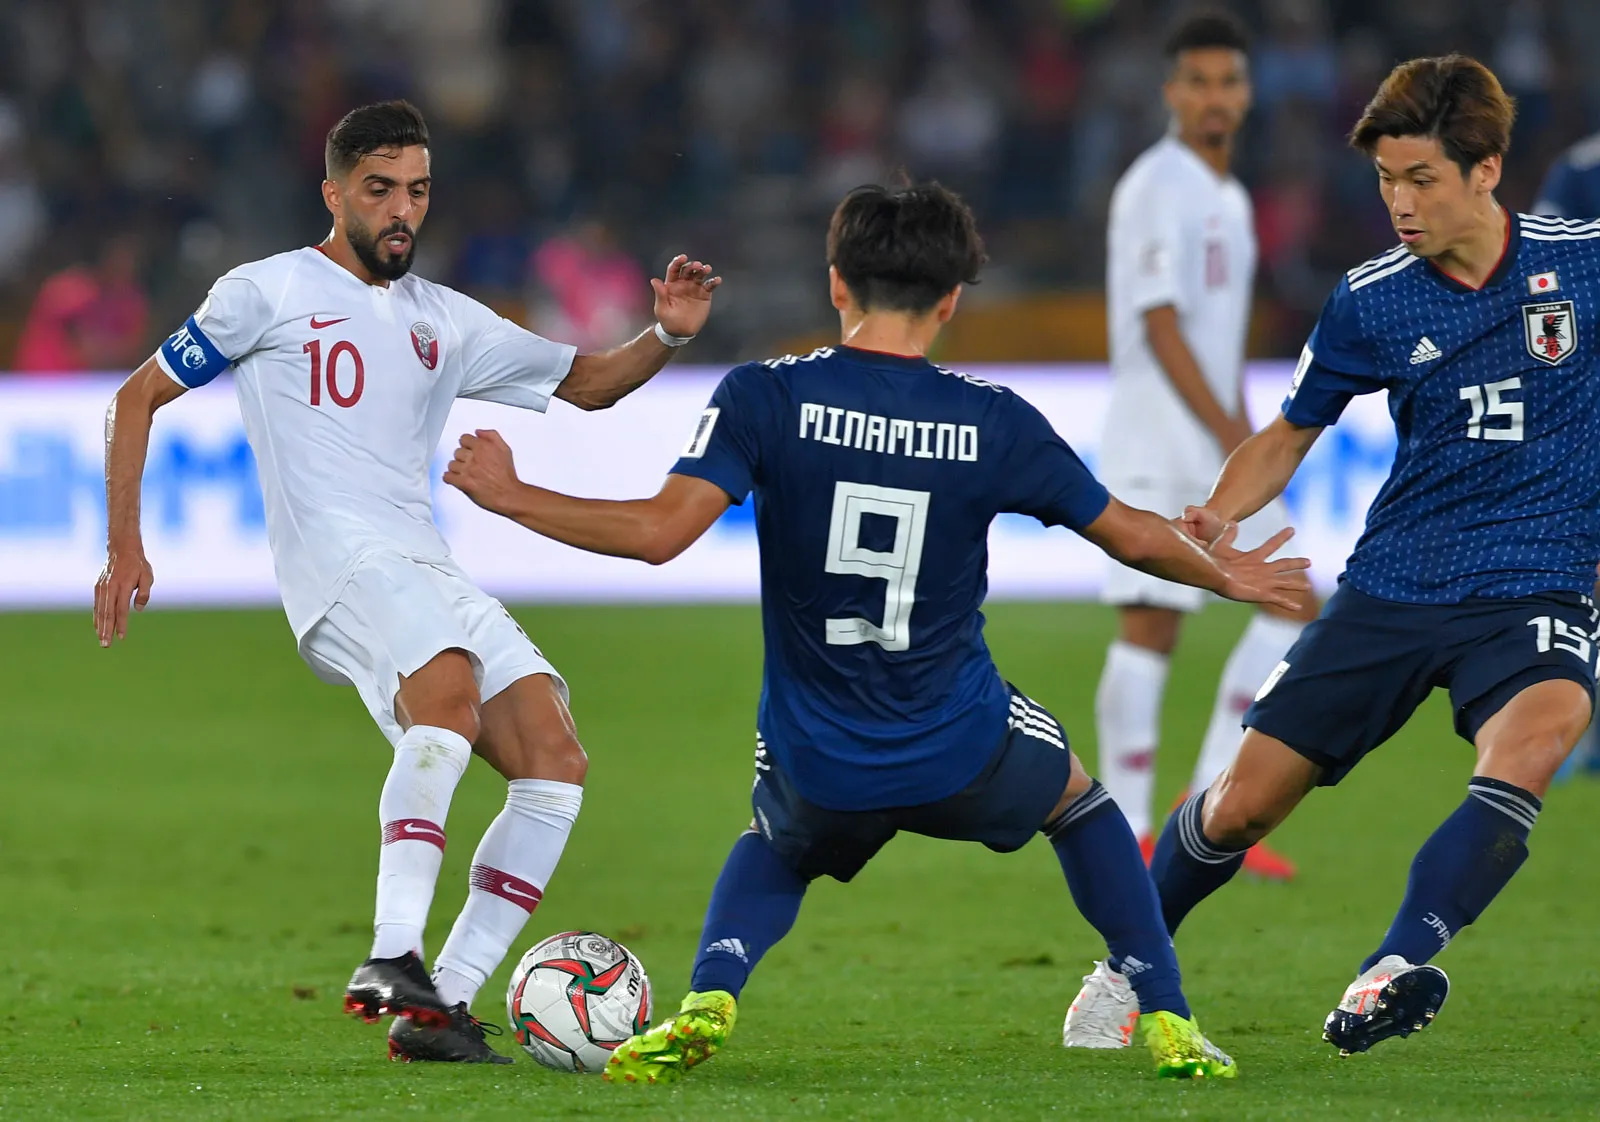

In [3]:
import requests
from PIL import Image

url = "https://github.com/RohanVolety/Yolov8-Sam2/blob/main/image-1.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image


In [ ]:
import requests
from PIL import Image

url = "https://github.com/RohanVolety/Yolov8-Sam2/blob/main/image-1.jpg?raw=true"
response = requests.get(url, stream=True)
image = Image.open(response.raw)
image.save("image-1.jpg")

!yolo predict model=yolov8n.pt source="image-1.jpg"


In [ ]:
model = YOLO('/content/yolov8n.pt')
results = model.predict(source='/content/image-1.jpg', conf=0.25)

### Display Image

In [ ]:
from IPython.display import Image, display

# Display the image
display(Image(filename='/content/runs/detect/predict2/image-1.jpg', height=600))


In [ ]:
results

In [8]:
all_boxes = []
for result in results:
    boxes = result.boxes
    all_boxes.extend(boxes.xyxy.tolist())

In [9]:
all_boxes

[[503.97857666015625, 932.117919921875, 652.26806640625, 1076.9967041015625],
 [89.78652954101562, 96.27593994140625, 722.6420288085938, 1051.244140625],
 [439.0317077636719, 185.78033447265625, 1354.522705078125, 1062.47607421875],
 [1143.947021484375, 52.975616455078125, 1599.7899169921875, 1061.69970703125],
 [1095.9217529296875, 22.535018920898438, 1266.6590576171875, 522.23193359375],
 [1094.327392578125,
  12.088851928710938,
  1287.6766357421875,
  830.9991455078125],
 [7.52903938293457, 245.55331420898438, 155.5316925048828, 374.7931213378906],
 [649.786376953125, 253.3077392578125, 719.9301147460938, 342.6372375488281]]

# **Now using SAM2 to Segment Images**


In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

In [10]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [11]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


In [12]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [ ]:
!mkdir -p {HOME}/checkpoints
# # !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
# # !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
# # !wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [15]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Initialize SAM2 model
checkpoint = f"{HOME}/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"


# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Build and load SAM2 model
sam2_model = build_sam2(model_cfg, checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

# Read and prepare the image
image_path = 'https://github.com/RohanVolety/Yolov8-Sam2/blob/main/image-1.jpg?raw=true'
image = Image.open(requests.get(url, stream=True).raw)
predictor.set_image(image)

In [16]:
all_boxes

[[503.97857666015625, 932.117919921875, 652.26806640625, 1076.9967041015625],
 [89.78652954101562, 96.27593994140625, 722.6420288085938, 1051.244140625],
 [439.0317077636719, 185.78033447265625, 1354.522705078125, 1062.47607421875],
 [1143.947021484375, 52.975616455078125, 1599.7899169921875, 1061.69970703125],
 [1095.9217529296875, 22.535018920898438, 1266.6590576171875, 522.23193359375],
 [1094.327392578125,
  12.088851928710938,
  1287.6766357421875,
  830.9991455078125],
 [7.52903938293457, 245.55331420898438, 155.5316925048828, 374.7931213378906],
 [649.786376953125, 253.3077392578125, 719.9301147460938, 342.6372375488281]]

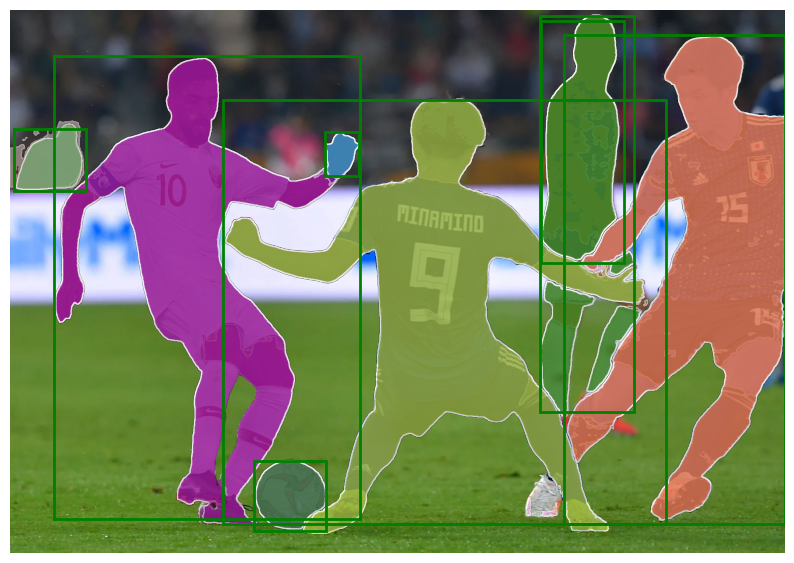

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(image)

for bbox in all_boxes:
    input_box = np.array(bbox)
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=True
    )
    # Display each mask
    for mask in masks:
        show_mask(mask, plt.gca(), random_color=True)    
    show_box(input_box, plt.gca())

plt.axis('off')
plt.show()


